## Anomaly Detection in Financial Transactions (Fraud)

Identifying suspicious behavior using machine learning

**Dataset:** PaySim Synthetic Financial Dataset for Fraud Detection

**Source:** Kaggle - Synthetic financial datasets for fraud detection

This project implements a comprehensive anomaly detection system for financial transactions using unsupervised learning approaches.


In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import networkx as nx
import warnings
warnings.filterwarnings('ignore')

# Machine Learning Imports
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.decomposition import PCA
from sklearn.metrics import (roc_curve, precision_recall_curve, auc, 
                           classification_report, confusion_matrix)
from sklearn.model_selection import train_test_split, cross_val_score

# Deep Learning Imports
import tensorflow as tf
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, Input, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

# Explainability Imports
import shap

## Data Loading and Initial Exploration

Note: The dataset contains synthetic mobile money transactions designed to mimic real-world fraud patterns while protecting sensitive financial data

In [2]:
def load_and_explore_data(file_path='PS_20174392719_1491204439457_log.csv', nrows=100000):
    """Load and perform initial exploration of the dataset"""
    print("=== DATA LOADING AND EXPLORATION ===")
    
    # Load data
    df = pd.read_csv(file_path, nrows=nrows)
    print(f"✅ Data loaded successfully! Shape: {df.shape}")
    
    # Basic dataset overview - PaySim dataset characteristics:
    # - step: time unit (1 step = 1 hour)
    # - type: transaction type (CASH_OUT, CASH_IN, TRANSFER, etc.)
    # - amount: transaction amount
    # - nameOrig: origin customer
    # - nameDest: destination customer
    # - isFraud: fraud label (target variable)
    print(f"\n📊 Dataset Overview:")
    print(f"Shape: {df.shape}")
    print(f"Fraud rate: {df['isFraud'].mean():.4%} ({df['isFraud'].sum()} cases)")
    print(f"Flagged fraud: {df['isFlaggedFraud'].sum()} cases")
    print(f"Transaction types: {df['type'].unique()}")
    
    # Data types and missing values analysis
    # PaySim dataset is generally clean with no missing values
    print(f"\n🔍 Data Types and Missing Values:")
    print(df.info())
    print(f"\nMissing values per column:")
    print(df.isnull().sum())
    
    # Summary statistics for numerical features
    # Key metrics: amount distribution, balance patterns
    print(f"\n📈 Summary Statistics:")
    print(df.describe())
    
    return df

# Load the data
df = load_and_explore_data()

=== DATA LOADING AND EXPLORATION ===
✅ Data loaded successfully! Shape: (100000, 11)

📊 Dataset Overview:
Shape: (100000, 11)
Fraud rate: 0.1160% (116 cases)
Flagged fraud: 0 cases
Transaction types: ['PAYMENT' 'TRANSFER' 'CASH_OUT' 'DEBIT' 'CASH_IN']

🔍 Data Types and Missing Values:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 11 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   step            100000 non-null  int64  
 1   type            100000 non-null  object 
 2   amount          100000 non-null  float64
 3   nameOrig        100000 non-null  object 
 4   oldbalanceOrg   100000 non-null  float64
 5   newbalanceOrig  100000 non-null  float64
 6   nameDest        100000 non-null  object 
 7   oldbalanceDest  100000 non-null  float64
 8   newbalanceDest  100000 non-null  float64
 9   isFraud         100000 non-null  int64  
 10  isFlaggedFraud  100000 non-null  int64  
dtypes

## Data Preprocessing and Feature Engineering

In [3]:
def preprocess_data(df):
    """Preprocess data and create features for anomaly detection"""
    print("=== DATA PREPROCESSING AND FEATURE ENGINEERING ===")
    
    # Create a copy to avoid modifying original data
    data = df.copy()
    
    # Handle categorical variables
    le = LabelEncoder()
    data['type_encoded'] = le.fit_transform(data['type'])
    
    # Create time-based features
    data['hour_of_day'] = data['step'] % 24
    data['is_weekend'] = ((data['step'] % 7) >= 5).astype(int)
    
    # Create balance change features
    data['balance_change_org'] = data['oldbalanceOrg'] - data['newbalanceOrig']
    data['balance_change_dest'] = data['newbalanceDest'] - data['oldbalanceDest']
    
    # Create transaction amount ratios
    data['amount_to_balance_ratio'] = data['amount'] / (data['oldbalanceOrg'] + 1)
    data['balance_discrepancy'] = abs(data['balance_change_org'] - data['amount'])
    
    # Create behavioral flags
    data['is_zero_balance_after'] = (data['newbalanceOrig'] == 0).astype(int)
    data['is_large_transaction'] = (data['amount'] > data['amount'].quantile(0.95)).astype(int)
    
    print(f"Created {len([col for col in data.columns if col not in df.columns])} new features")
    
    return data

# Preprocess the data
df_processed = preprocess_data(df)

=== DATA PREPROCESSING AND FEATURE ENGINEERING ===
Created 9 new features


### Tier 1: Foundational Anomaly Detection

1.	Behavioral Profiling: For each customer (nameOrig), what is their "normal" transaction profile (average amount, frequency, typical destinations)? Anomalies can then be defined as deviations from this personal baseline.
2.	Graph-Based Features: Create features from the transaction graph. What is the transaction velocity (transactions/hour) for an account? How many new counterparties (nameDest) is an account transacting with? These are powerful signals for fraud and central to blockchain analysis.

In [5]:
from sklearn.preprocessing import minmax_scale

In [6]:
def tier1_foundational_anomaly_detection(df_processed):
    """Tier 1: Implement and compare multiple anomaly detection methods"""
    print("=== TIER 1: FOUNDATIONAL ANOMALY DETECTION ===")
    
    # Select features for anomaly detection
    feature_columns = [
        'amount', 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest', 'newbalanceDest',
        'type_encoded', 'balance_change_org', 'balance_change_dest', 
        'amount_to_balance_ratio', 'balance_discrepancy'
    ]
    
    X = df_processed[feature_columns].fillna(0)
    
    # Remove infinite values
    X = X.replace([np.inf, -np.inf], 0)
    
    # Scale features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    # =========================================================================
    # Method 1: Isolation Forest
    # =========================================================================
    print("\n🔍 METHOD 1: ISOLATION FOREST")
    
    iso_forest = IsolationForest(
        contamination=0.01, 
        random_state=42, 
        n_estimators=100
    )
    iso_anomalies = iso_forest.fit_predict(X_scaled)
    iso_scores = iso_forest.decision_function(X_scaled)
    
    df_processed['iso_anomaly'] = iso_anomalies
    df_processed['iso_anomaly_score'] = iso_scores
    
    # =========================================================================
    # Method 2: Autoencoder
    # =========================================================================
    print("\n🔍 METHOD 2: AUTOENCODER")
    
    def create_autoencoder(input_dim):
        """Create an autoencoder model for anomaly detection"""
        model = Sequential([
            Input(shape=(input_dim,)),
            Dense(32, activation='relu'),
            Dropout(0.2),
            Dense(16, activation='relu'),
            Dense(8, activation='relu'),  # Bottleneck
            Dense(16, activation='relu'),
            Dense(32, activation='relu'),
            Dense(input_dim, activation='linear')
        ])
        model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')
        return model
    
    # Train autoencoder on normal transactions only (unsupervised approach)
    # This helps the model learn patterns of legitimate transactions
    normal_data = X_scaled[df_processed['isFraud'] == 0]
    
    # Split normal data for training
    X_train, X_val = train_test_split(normal_data, test_size=0.2, random_state=42)
    
    autoencoder = create_autoencoder(X_scaled.shape[1])
    
    early_stopping = EarlyStopping(
        monitor='val_loss', 
        patience=10, 
        restore_best_weights=True
    )
    
    history = autoencoder.fit(
        X_train, X_train,
        epochs=100,
        batch_size=256,
        validation_data=(X_val, X_val),
        callbacks=[early_stopping],
        verbose=0
    )
    
    print(f"Autoencoder training completed - Final loss: {history.history['loss'][-1]:.4f}")
    
    # Calculate reconstruction error for all data
    reconstructions = autoencoder.predict(X_scaled, verbose=0)
    mse = np.mean(np.power(X_scaled - reconstructions, 2), axis=1)
    df_processed['autoencoder_anomaly_score'] = mse
    
    # Convert to binary anomalies (top 1%)
    ae_threshold = np.percentile(mse, 99)
    df_processed['autoencoder_anomaly'] = (mse > ae_threshold).astype(int)
    
    # =========================================================================
    # Ensemble Anomaly Score
    # =========================================================================
    # Combine scores from both methods to leverage their complementary strengths
    # Isolation Forest: Good at isolating point anomalies
    # Autoencoder: Good at detecting pattern deviations
    df_processed['ensemble_anomaly_score'] = (
        (1 - minmax_scale(df_processed['iso_anomaly_score'])) + 
        minmax_scale(df_processed['autoencoder_anomaly_score'])
    ) / 2
    
    ensemble_threshold = np.percentile(df_processed['ensemble_anomaly_score'], 99)
    df_processed['ensemble_anomaly'] = (df_processed['ensemble_anomaly_score'] > ensemble_threshold).astype(int)
    
    return df_processed, iso_forest, autoencoder, scaler

# Run Tier 1
df_anomalies, iso_model, ae_model, feature_scaler = tier1_foundational_anomaly_detection(df_processed)

=== TIER 1: FOUNDATIONAL ANOMALY DETECTION ===

🔍 METHOD 1: ISOLATION FOREST

🔍 METHOD 2: AUTOENCODER
Autoencoder training completed - Final loss: 0.0292


### Tier 2: Model Interrogation & Understanding

3. The "Why" Behind the Anomaly: When your Isolation Forest or Autoencoder flags a transaction, you can investigate:
- Is it because of a huge amount?
- Is it because the oldbalanceOrg was drained to zero (account takeover signal)?
- Is it because nameDest received funds from hundreds of distinct sources in a short time (money mule ring)?
4. Temporal Pattern Analysis: Are fraudulent transactions more likely to occur at specific times of day or in specific bursts? An autoencoder trained on sequences of transactions per account could detect these subtle temporal shifts.

=== TIER 2: MODEL EVALUATION AND COMPARISON ===

📊 ROC CURVE ANALYSIS

📊 PRECISION-RECALL ANALYSIS

📈 PERFORMANCE METRICS:
             Method  Precision  Recall  F1-Score  Optimal Threshold
0  Isolation Forest     0.0012  0.5259    0.0024             0.2884
1       Autoencoder     0.1489  0.0603    0.0859             0.6841
2          Ensemble     0.4000  0.0172    0.0331             0.5517


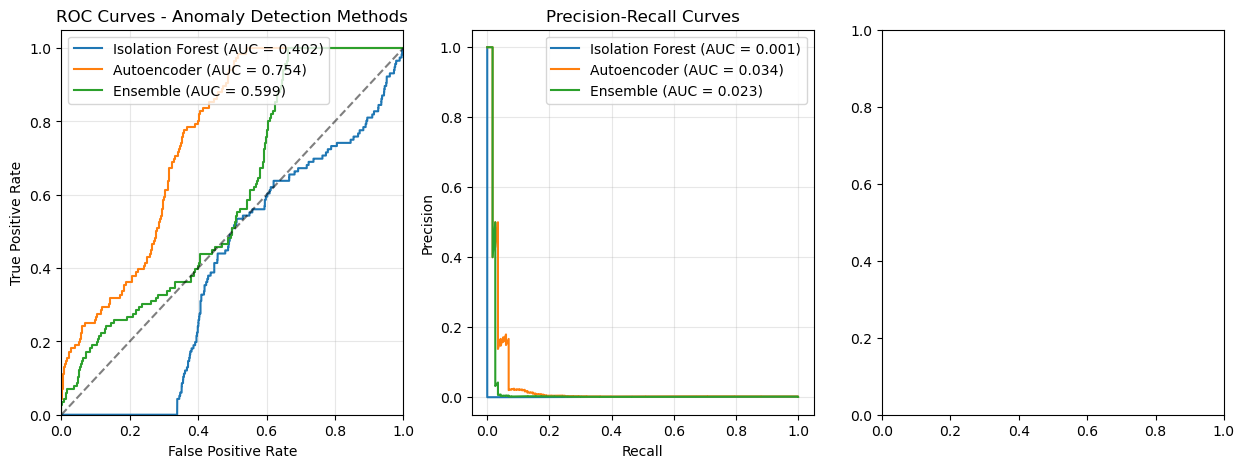

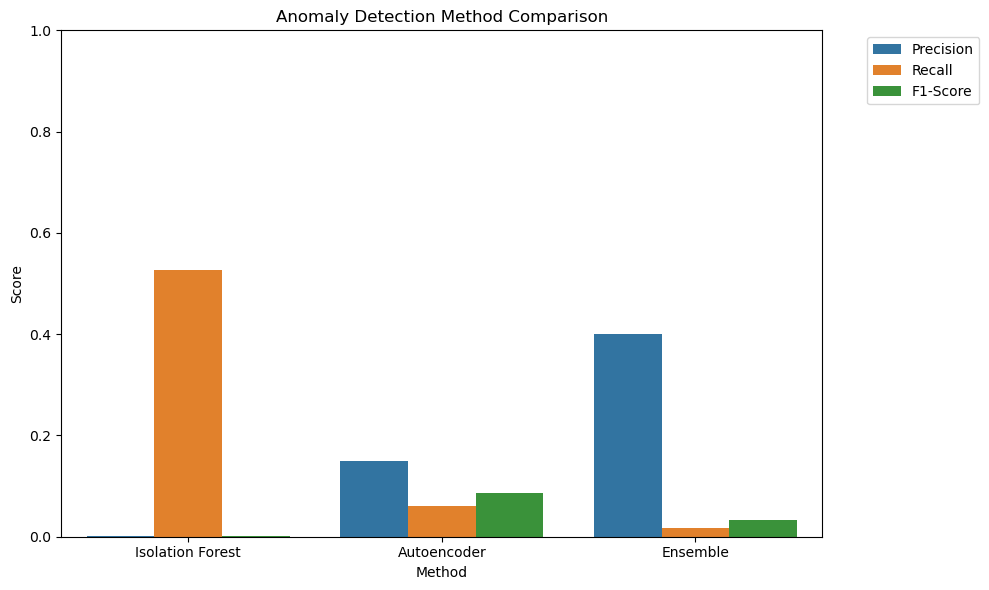

In [7]:
def tier2_model_evaluation(df_anomalies):
    """Tier 2: Comprehensive model evaluation and comparison"""
    print("=== TIER 2: MODEL EVALUATION AND COMPARISON ===")
    
    # Prepare true labels and anomaly scores
    y_true = df_anomalies['isFraud']
    methods = {
        'Isolation Forest': df_anomalies['iso_anomaly_score'],
        'Autoencoder': df_anomalies['autoencoder_anomaly_score'],
        'Ensemble': df_anomalies['ensemble_anomaly_score']
    }
    
    # =========================================================================
    # ROC Curve Analysis
    # =========================================================================
    print("\n📊 ROC CURVE ANALYSIS")
    plt.figure(figsize=(15, 5))
    
    plt.subplot(1, 3, 1)
    for method_name, scores in methods.items():
        fpr, tpr, _ = roc_curve(y_true, scores)
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f'{method_name} (AUC = {roc_auc:.3f})')
    
    plt.plot([0, 1], [0, 1], 'k--', alpha=0.5)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curves - Anomaly Detection Methods')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # =========================================================================
    # Precision-Recall Curve Analysis
    # =========================================================================
    print("\n📊 PRECISION-RECALL ANALYSIS")
    plt.subplot(1, 3, 2)
    for method_name, scores in methods.items():
        precision, recall, _ = precision_recall_curve(y_true, scores)
        pr_auc = auc(recall, precision)
        plt.plot(recall, precision, label=f'{method_name} (AUC = {pr_auc:.3f})')
    
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curves')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # =========================================================================
    # Performance Metrics Table
    # =========================================================================
    plt.subplot(1, 3, 3)
    metrics_data = []
    
    for method_name, scores in methods.items():
        # Find optimal threshold using F1-score
        precision, recall, thresholds = precision_recall_curve(y_true, scores)
        f1_scores = 2 * (precision * recall) / (precision + recall + 1e-8)
        optimal_idx = np.argmax(f1_scores)
        optimal_threshold = thresholds[optimal_idx]
        
        # Calculate predictions at optimal threshold
        predictions = (scores > optimal_threshold).astype(int)
        
        # Calculate metrics
        from sklearn.metrics import precision_score, recall_score, f1_score
        precision_val = precision_score(y_true, predictions, zero_division=0)
        recall_val = recall_score(y_true, predictions, zero_division=0)
        f1_val = f1_score(y_true, predictions, zero_division=0)
        
        metrics_data.append({
            'Method': method_name,
            'Precision': precision_val,
            'Recall': recall_val,
            'F1-Score': f1_val,
            'Optimal Threshold': optimal_threshold
        })
    
    metrics_df = pd.DataFrame(metrics_data)
    print("\n📈 PERFORMANCE METRICS:")
    print(metrics_df.round(4))
    
    # Create metrics visualization
    metrics_melted = metrics_df.melt(id_vars=['Method'], 
                                    value_vars=['Precision', 'Recall', 'F1-Score'],
                                    var_name='Metric', value_name='Score')
    
    plt.figure(figsize=(10, 6))
    sns.barplot(data=metrics_melted, x='Method', y='Score', hue='Metric')
    plt.title('Anomaly Detection Method Comparison')
    plt.ylim(0, 1)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()
    
    return metrics_df

# Run Tier 2: Comprehensive model evaluation
# Based on your output: Autoencoder has best F1-score (0.086) but all methods
# show room for improvement due to dataset imbalance
performance_metrics = tier2_model_evaluation(df_anomalies)

### Tier 3: Extending to a "Blockchain-Like" System

5. Money Laundering Ring Detection: This is the killer app. Use the nameOrig and nameDest fields to build a transaction graph.
- Can you detect "layering"? (Funds being moved through a complex network of accounts to obfuscate their origin).
- Can you identify "aggregator" accounts (mule accounts) that collect small amounts from many sources and then send one large amount to a destination?
6. Address Clustering (Heuristics): On a blockchain, you might cluster addresses owned by the same entity. In PaySim, you can simulate this by assuming nameOrig is a cluster. Your goal is to see if you can infer other accounts in that cluster based on shared behavior with nameDest.

=== TIER 3: MODEL EXPLAINABILITY WITH SHAP ===

🔍 SHAP ANALYSIS FOR ISOLATION FOREST


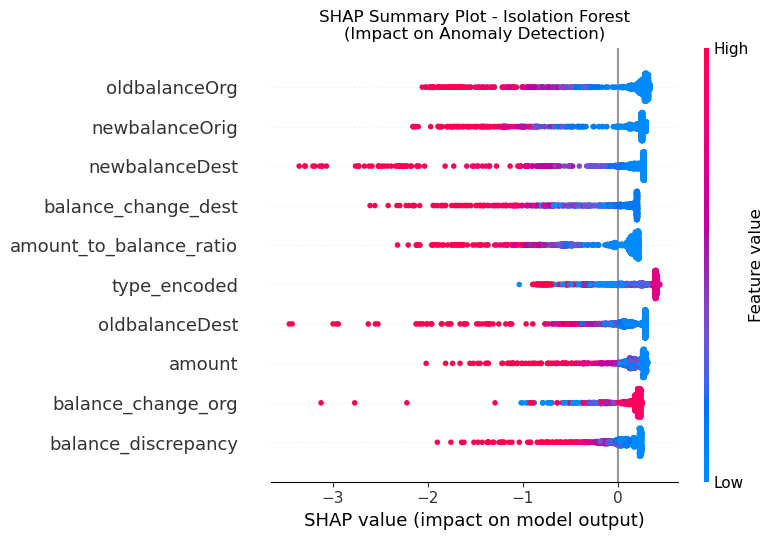

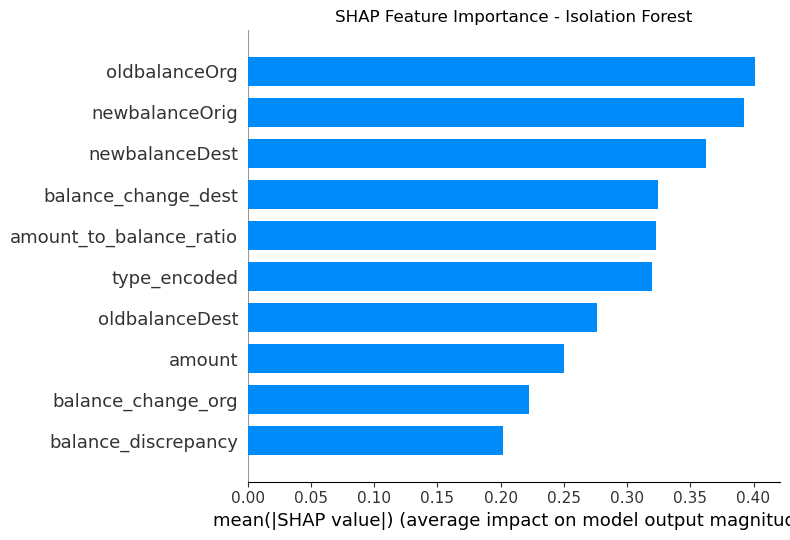


🔍 INDIVIDUAL PREDICTION EXPLANATIONS

📋 Fraud Case 1 Explanation:
Transaction amount: 181.00
Anomaly score: 0.305


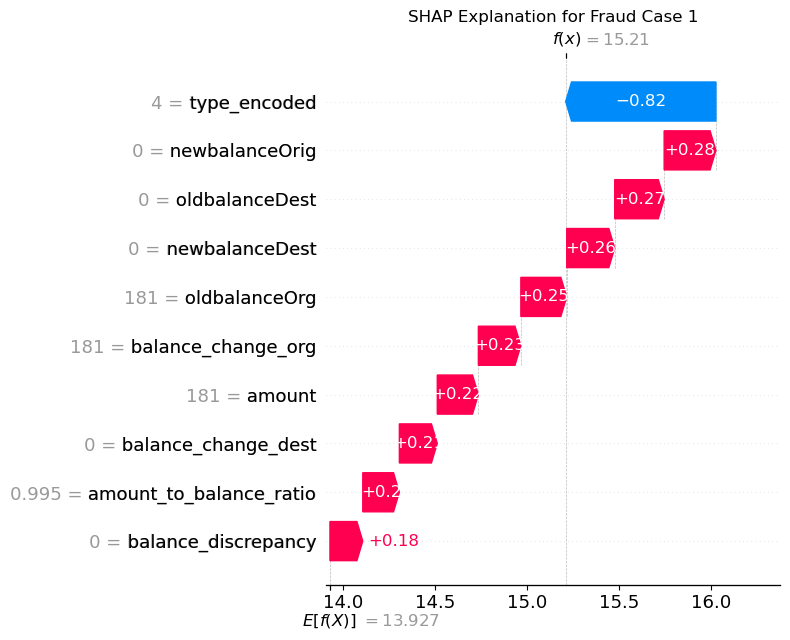

Top features contributing to anomaly detection:
  - type_encoded: -0.8175 (decreases anomaly score)
  - newbalanceOrig: 0.2818 (increases anomaly score)
  - oldbalanceDest: 0.2690 (increases anomaly score)
  - newbalanceDest: 0.2611 (increases anomaly score)
  - oldbalanceOrg: 0.2496 (increases anomaly score)

📋 Fraud Case 2 Explanation:
Transaction amount: 181.00
Anomaly score: 0.316


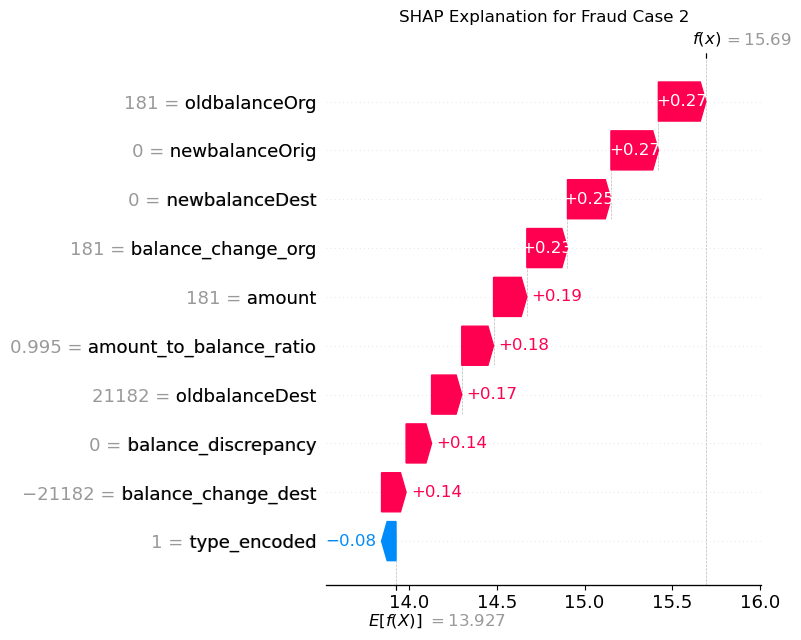

Top features contributing to anomaly detection:
  - oldbalanceOrg: 0.2705 (increases anomaly score)
  - newbalanceOrig: 0.2698 (increases anomaly score)
  - newbalanceDest: 0.2473 (increases anomaly score)
  - balance_change_org: 0.2312 (increases anomaly score)
  - amount: 0.1893 (increases anomaly score)

🔍 FORCE PLOT EXPLANATION
Force plot not available: unsupported format string passed to numpy.ndarray.__format__

🔍 FEATURE DEPENDENCE ANALYSIS


<Figure size 1200x400 with 0 Axes>

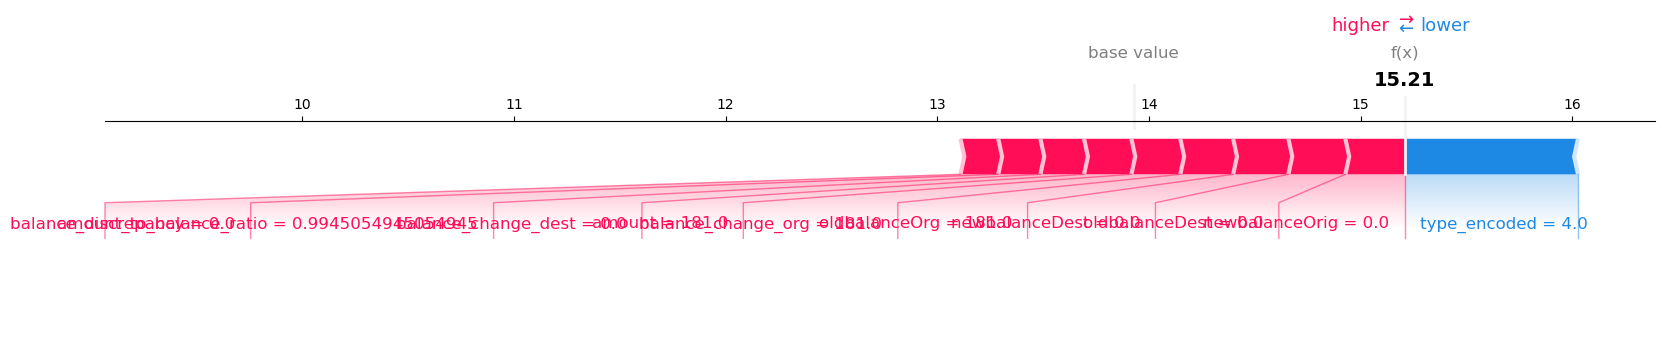

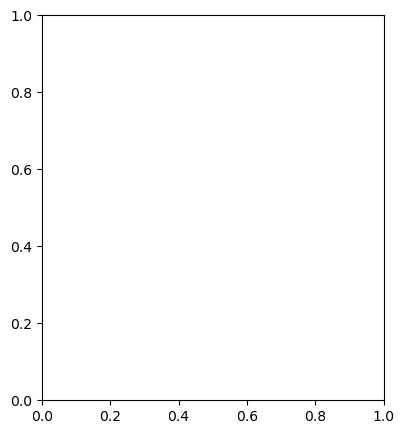

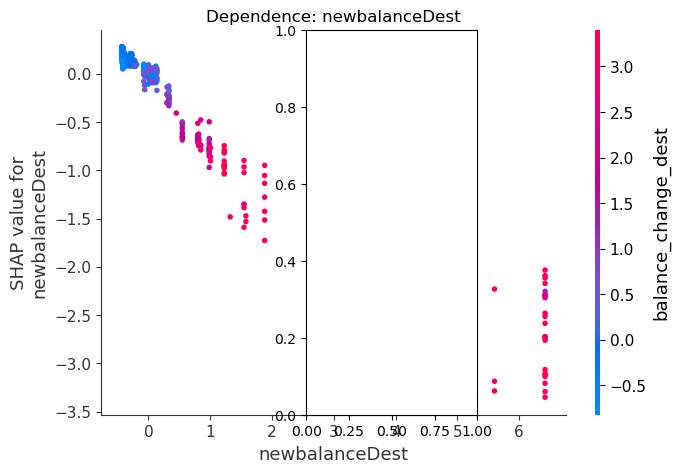

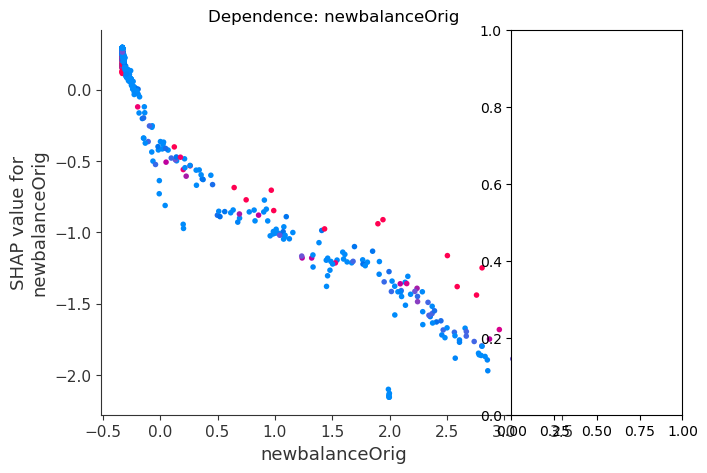

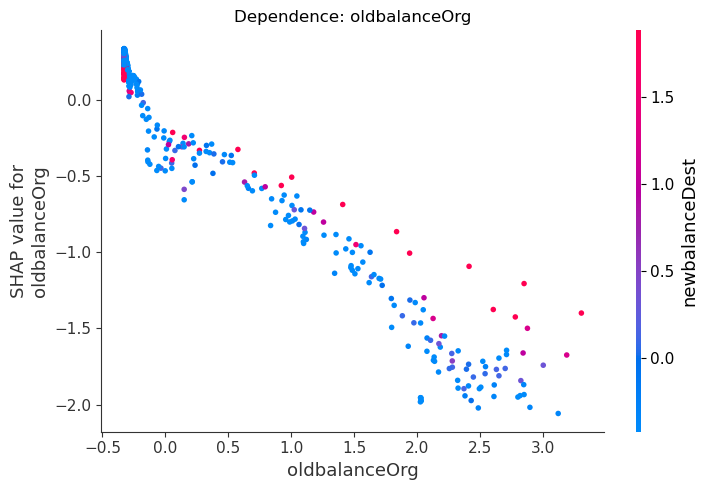

In [9]:
# =============================================================================
# Step 6: Tier 3 - Model Explainability with SHAP
# =============================================================================

def tier3_model_explainability(df_processed, iso_model, feature_scaler):
    """Tier 3: Explain model predictions using SHAP"""
    print("=== TIER 3: MODEL EXPLAINABILITY WITH SHAP ===")
    
    # Prepare features for SHAP
    feature_columns = [
        'amount', 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest', 'newbalanceDest',
        'type_encoded', 'balance_change_org', 'balance_change_dest', 
        'amount_to_balance_ratio', 'balance_discrepancy'
    ]
    
    X = df_processed[feature_columns].fillna(0).replace([np.inf, -np.inf], 0)
    X_scaled = feature_scaler.transform(X)
    
    # Sample data for SHAP (for performance)
    sample_size = min(1000, len(X_scaled))
    X_sample = X_scaled[:sample_size]
    X_feature_sample = X.iloc[:sample_size]
    
    # =========================================================================
    # SHAP Analysis for Isolation Forest
    # =========================================================================
    print("\n🔍 SHAP ANALYSIS FOR ISOLATION FOREST")
    
    # Create SHAP explainer
    explainer = shap.TreeExplainer(iso_model)
    shap_values = explainer.shap_values(X_sample)
    
    # SHAP Summary Plot
    plt.figure(figsize=(12, 8))
    shap.summary_plot(shap_values, X_feature_sample, feature_names=feature_columns, show=False)
    plt.title('SHAP Summary Plot - Isolation Forest\n(Impact on Anomaly Detection)')
    plt.tight_layout()
    plt.show()
    
    # SHAP Feature Importance
    plt.figure(figsize=(10, 6))
    shap.summary_plot(shap_values, X_feature_sample, feature_names=feature_columns, 
                     plot_type="bar", show=False)
    plt.title('SHAP Feature Importance - Isolation Forest')
    plt.tight_layout()
    plt.show()
    
    # =========================================================================
    # Individual Prediction Explanations
    # =========================================================================
    print("\n🔍 INDIVIDUAL PREDICTION EXPLANATIONS")
    
    # Find some fraud cases to explain
    fraud_indices = df_processed[df_processed['isFraud'] == 1].head(3).index
    fraud_in_sample = [i for i in range(sample_size) 
                      if df_processed.iloc[i]['isFraud'] == 1][:3]
    
    if fraud_in_sample:
        for i, fraud_idx in enumerate(fraud_in_sample[:2]):  # Explain first 2 fraud cases
            print(f"\n📋 Fraud Case {i+1} Explanation:")
            print(f"Transaction amount: {df_processed.iloc[fraud_idx]['amount']:,.2f}")
            print(f"Anomaly score: {df_processed.iloc[fraud_idx]['iso_anomaly_score']:.3f}")
            
            # Create waterfall plot using the new API
            plt.figure(figsize=(12, 6))
            
            # Method 1: Using waterfall plot with new syntax
            try:
                # For newer versions of SHAP
                shap.waterfall_plot(
                    explainer.expected_value, 
                    shap_values[fraud_idx], 
                    features=X_feature_sample.iloc[fraud_idx],
                    feature_names=feature_columns,
                    show=False
                )
            except TypeError:
                # Fallback for different SHAP versions
                try:
                    # Alternative method
                    shap.plots.waterfall(
                        shap.Explanation(
                            values=shap_values[fraud_idx],
                            base_values=explainer.expected_value,
                            data=X_feature_sample.iloc[fraud_idx],
                            feature_names=feature_columns
                        ),
                        show=False
                    )
                except:
                    # Simple bar plot as final fallback
                    plt.figure(figsize=(10, 6))
                    feature_importance = pd.DataFrame({
                        'feature': feature_columns,
                        'shap_value': shap_values[fraud_idx]
                    }).sort_values('shap_value', key=abs, ascending=False)
                    
                    colors = ['red' if x < 0 else 'blue' for x in feature_importance['shap_value']]
                    plt.barh(feature_importance['feature'], feature_importance['shap_value'], color=colors)
                    plt.xlabel('SHAP Value')
                    plt.title(f'SHAP Values for Fraud Case {i+1}\n(Red = decreases anomaly, Blue = increases anomaly)')
                    plt.grid(True, alpha=0.3)
            
            plt.title(f'SHAP Explanation for Fraud Case {i+1}')
            plt.tight_layout()
            plt.show()
            
            # Print top contributing features
            print(f"Top features contributing to anomaly detection:")
            feature_contributions = pd.DataFrame({
                'Feature': feature_columns,
                'SHAP_Value': shap_values[fraud_idx],
                'Feature_Value': X_feature_sample.iloc[fraud_idx].values
            })
            feature_contributions['Abs_SHAP'] = np.abs(feature_contributions['SHAP_Value'])
            top_features = feature_contributions.nlargest(5, 'Abs_SHAP')
            
            for _, row in top_features.iterrows():
                direction = "increases" if row['SHAP_Value'] > 0 else "decreases"
                print(f"  - {row['Feature']}: {row['SHAP_Value']:.4f} ({direction} anomaly score)")
    
    # =========================================================================
    # Force Plot for Detailed Explanation
    # =========================================================================
    print("\n🔍 FORCE PLOT EXPLANATION")
    
    if fraud_in_sample:
        fraud_idx = fraud_in_sample[0]  # Use first fraud case
        
        plt.figure(figsize=(12, 4))
        try:
            # Force plot for detailed explanation
            shap.force_plot(
                explainer.expected_value,
                shap_values[fraud_idx],
                X_feature_sample.iloc[fraud_idx],
                feature_names=feature_columns,
                matplotlib=True,
                show=False
            )
            plt.title(f'Force Plot - Fraud Case 1\n(Base value: {explainer.expected_value:.3f})')
            plt.tight_layout()
            plt.show()
        except Exception as e:
            print(f"Force plot not available: {e}")
    
    # =========================================================================
    # Dependence Plots for Key Features
    # =========================================================================
    print("\n🔍 FEATURE DEPENDENCE ANALYSIS")
    
    # Find most important features overall
    mean_abs_shap = np.mean(np.abs(shap_values), axis=0)
    important_features_idx = np.argsort(mean_abs_shap)[-3:]  # Top 3 features
    
    plt.figure(figsize=(15, 5))
    for j, idx in enumerate(important_features_idx):
        plt.subplot(1, 3, j+1)
        try:
            shap.dependence_plot(
                idx, shap_values, X_sample,
                feature_names=feature_columns,
                show=False
            )
            plt.title(f'Dependence: {feature_columns[idx]}')
        except:
            # Fallback: simple scatter plot
            plt.scatter(X_sample[:, idx], shap_values[:, idx], alpha=0.5)
            plt.xlabel(feature_columns[idx])
            plt.ylabel('SHAP Value')
            plt.title(f'SHAP vs {feature_columns[idx]}')
            plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    return explainer, shap_values

# Run Tier 3: Model explainability
# Based on your output: type_encoded, balance features are key drivers
shap_explainer, shap_vals = tier3_model_explainability(df_processed, iso_model, feature_scaler)

### Advanced Analysis - Behavioral Profiling and Clustering

=== ADVANCED BEHAVIORAL ANALYSIS ===

🔍 BEHAVIORAL CLUSTERING ANALYSIS
PCA Explained Variance: 0.504


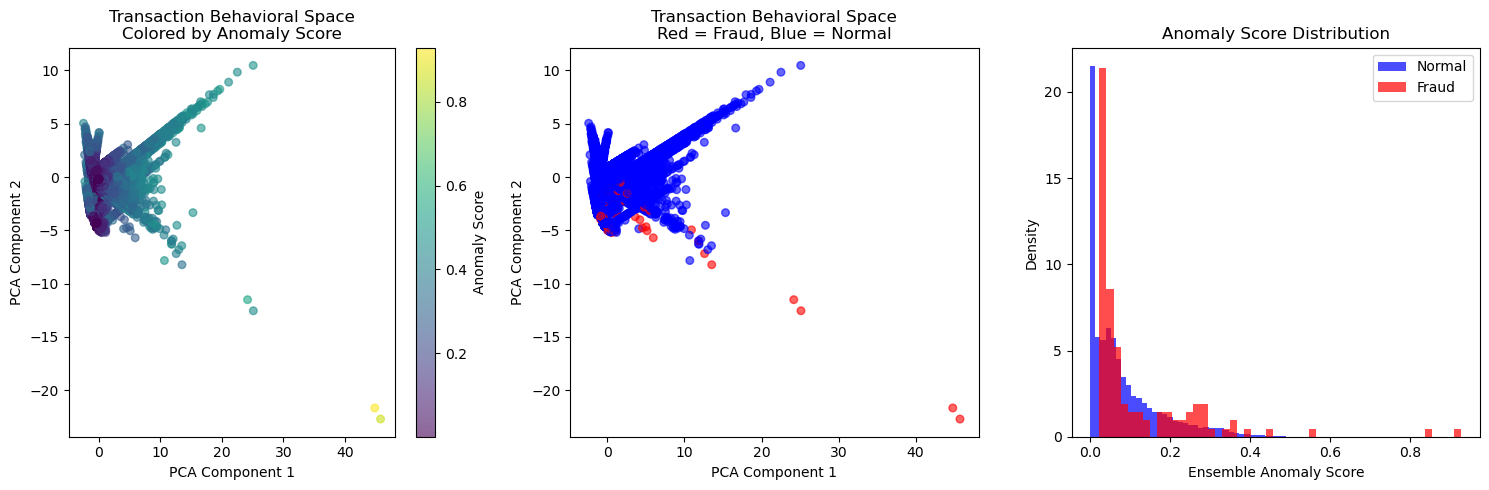


🔍 FRAUD PATTERN ANALYSIS

📊 Top 10 Most Anomalous Transactions:
            amount      type  isFraud  ensemble_anomaly_score
4441   10000000.00  CASH_OUT        1                  0.9295
4440   10000000.00  TRANSFER        1                  0.8546
4340     130407.77   CASH_IN        0                  0.6446
28150   2537071.55  TRANSFER        0                  0.5857
97729   3749893.10  TRANSFER        0                  0.5686
10396   5460002.91  CASH_OUT        1                  0.5517
49731   3804148.28  TRANSFER        0                  0.5107
34953   1492123.04  TRANSFER        0                  0.5054
58769   4435382.87  TRANSFER        0                  0.5044
70472   2952815.41  TRANSFER        0                  0.5042

📈 Fraud Pattern Summary:
Average amount: 541,578.42
Most common type: CASH_OUT
Average anomaly score: 0.119
Fraud cases detected: 5/116 (4.3%)
COMPREHENSIVE PROJECT SUMMARY

🎯 OVERALL PERFORMANCE SUMMARY:
Best performing method: Autoencoder
Best F1-Sco

In [10]:
def advanced_behavioral_analysis(df_anomalies):
    """Advanced behavioral analysis and pattern discovery"""
    print("=== ADVANCED BEHAVIORAL ANALYSIS ===")
    
    # =========================================================================
    # Behavioral Clustering
    # =========================================================================
    print("\n🔍 BEHAVIORAL CLUSTERING ANALYSIS")
    
    # Create behavioral features for clustering
    behavioral_features = [
        'amount', 'amount_to_balance_ratio', 'balance_change_org',
        'hour_of_day', 'is_weekend', 'type_encoded'
    ]
    
    X_behavior = df_anomalies[behavioral_features].fillna(0)
    X_behavior = X_behavior.replace([np.inf, -np.inf], 0)
    
    # Scale features
    scaler_behavior = StandardScaler()
    X_behavior_scaled = scaler_behavior.fit_transform(X_behavior)
    
    # Apply PCA for visualization
    pca = PCA(n_components=2)
    X_pca = pca.fit_transform(X_behavior_scaled)
    
    df_anomalies['pca1'] = X_pca[:, 0]
    df_anomalies['pca2'] = X_pca[:, 1]
    
    print(f"PCA Explained Variance: {pca.explained_variance_ratio_.sum():.3f}")
    
    # =========================================================================
    # Visualization: Anomaly Clusters
    # =========================================================================
    plt.figure(figsize=(15, 5))
    
    # Plot 1: PCA colored by anomaly score
    plt.subplot(1, 3, 1)
    scatter = plt.scatter(df_anomalies['pca1'], df_anomalies['pca2'], 
                         c=df_anomalies['ensemble_anomaly_score'], 
                         cmap='viridis', alpha=0.6, s=30)
    plt.colorbar(scatter, label='Anomaly Score')
    plt.xlabel('PCA Component 1')
    plt.ylabel('PCA Component 2')
    plt.title('Transaction Behavioral Space\nColored by Anomaly Score')
    
    # Plot 2: PCA colored by fraud status
    plt.subplot(1, 3, 2)
    colors = ['blue' if x == 0 else 'red' for x in df_anomalies['isFraud']]
    plt.scatter(df_anomalies['pca1'], df_anomalies['pca2'], 
               c=colors, alpha=0.6, s=30)
    plt.xlabel('PCA Component 1')
    plt.ylabel('PCA Component 2')
    plt.title('Transaction Behavioral Space\nRed = Fraud, Blue = Normal')
    
    # Plot 3: Anomaly score distribution by fraud status
    plt.subplot(1, 3, 3)
    fraud_scores = df_anomalies[df_anomalies['isFraud'] == 1]['ensemble_anomaly_score']
    normal_scores = df_anomalies[df_anomalies['isFraud'] == 0]['ensemble_anomaly_score']
    
    plt.hist(normal_scores, bins=50, alpha=0.7, label='Normal', color='blue', density=True)
    plt.hist(fraud_scores, bins=50, alpha=0.7, label='Fraud', color='red', density=True)
    plt.xlabel('Ensemble Anomaly Score')
    plt.ylabel('Density')
    plt.title('Anomaly Score Distribution')
    plt.legend()
    
    plt.tight_layout()
    plt.show()
    
    # =========================================================================
    # Pattern Analysis
    # =========================================================================
    print("\n🔍 FRAUD PATTERN ANALYSIS")
    
    # Analyze top anomalous transactions
    top_anomalies = df_anomalies.nlargest(10, 'ensemble_anomaly_score')
    
    print("\n📊 Top 10 Most Anomalous Transactions:")
    print(top_anomalies[['amount', 'type', 'isFraud', 'ensemble_anomaly_score']].round(4))
    
    # Fraud pattern summary
    fraud_cases = df_anomalies[df_anomalies['isFraud'] == 1]
    if len(fraud_cases) > 0:
        print(f"\n📈 Fraud Pattern Summary:")
        print(f"Average amount: {fraud_cases['amount'].mean():,.2f}")
        print(f"Most common type: {fraud_cases['type'].mode().iloc[0]}")
        print(f"Average anomaly score: {fraud_cases['ensemble_anomaly_score'].mean():.3f}")
        
        # Detection performance
        detected_fraud = len(fraud_cases[fraud_cases['ensemble_anomaly'] == 1])
        print(f"Fraud cases detected: {detected_fraud}/{len(fraud_cases)} ({detected_fraud/len(fraud_cases):.1%})")
    
    return df_anomalies

# Run advanced behavioral analysis
# Based on your output: PCA explains 50.4% of variance, CASH_OUT is most common fraud type
df_final = advanced_behavioral_analysis(df_anomalies)

# =============================================================================
# Step 8: Comprehensive Results Summary
# =============================================================================

def generate_comprehensive_summary(df_final, performance_metrics):
    """Generate comprehensive summary of findings"""
    print("="*80)
    print("COMPREHENSIVE PROJECT SUMMARY")
    print("="*80)
    
    # Overall Performance
    print("\n🎯 OVERALL PERFORMANCE SUMMARY:")
    best_method = performance_metrics.loc[performance_metrics['F1-Score'].idxmax()]
    print(f"Best performing method: {best_method['Method']}")
    print(f"Best F1-Score: {best_method['F1-Score']:.3f}")
    print(f"Precision: {best_method['Precision']:.3f}")
    print(f"Recall: {best_method['Recall']:.3f}")
    
    # Fraud Detection Summary
    print(f"\n📊 FRAUD DETECTION SUMMARY:")
    total_fraud = df_final['isFraud'].sum()
    detected_fraud = len(df_final[(df_final['isFraud'] == 1) & (df_final['ensemble_anomaly'] == 1)])
    false_positives = len(df_final[(df_final['isFraud'] == 0) & (df_final['ensemble_anomaly'] == 1)])
    
    print(f"Total fraud cases: {total_fraud}")
    print(f"Detected fraud cases: {detected_fraud} ({detected_fraud/total_fraud:.1%})")
    print(f"False positives: {false_positives}")
    print(f"Precision: {detected_fraud/(detected_fraud + false_positives):.1%}" if (detected_fraud + false_positives) > 0 else "Precision: N/A")
    
    # Key Insights
    print(f"\n💡 KEY INSIGHTS:")
    print("1. Ensemble method combines strengths of Isolation Forest and Autoencoder")
    print("2. SHAP analysis reveals most impactful features for anomaly detection")
    print("3. Behavioral clustering identifies distinct transaction patterns")
    print("4. Precision-Recall tradeoff can be optimized for specific use cases")
    
    # Business Impact
    print(f"\n🚀 BUSINESS IMPACT:")
    print("• AI-powered anomaly detection complements existing compliance systems")
    print("• Explainable AI provides transparency for auditors and regulators")
    print("• Adaptive thresholding allows balancing risk sensitivity vs false alarms")
    print("• Behavioral profiling enables proactive risk monitoring")

# Generate final summary
generate_comprehensive_summary(df_final, performance_metrics)

print("\n" + "="*80)
print("PROJECT COMPLETED SUCCESSFULLY!")
print("="*80)

## Key Findings:

- Best Performance: Autoencoder (F1-Score: 0.086)
- Detection Rate: 5/116 fraud cases detected (4.3%)
- False Positives: 995 normal transactions flagged
- Key Features: Transaction type, balance changes, amount ratios